In [10]:
import sys
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

#Code from existing github repo provided by UC Irvine dataset
# sys.path.append(os.getcwd())
# import utils
# import equalizer
# from utils import cutCube
# from equalizer import histEq


In [11]:
processed_training_data = "Preprocessed_data/combined_tampered_scans_dataset_train.npy"
processed_training_labels = "Preprocessed_data/combined_tampered_scans_dataset_train_labels.npy"

processed_val_data = "Preprocessed_data/combined_tampered_scans_dataset_val.npy"
processed_val_labels = "Preprocessed_data/combined_tampered_scans_dataset_val_labels.npy"

processed_test_data = "Preprocessed_data/combined_tampered_scans_dataset_test.npy"
processed_test_labels = "Preprocessed_data/combined_tampered_scans_dataset_test_labels.npy"

In [12]:
from sklearn.preprocessing import LabelEncoder

# Loading Training data
loaded_train_data = np.load(processed_training_data)
loaded_train_labels = np.load(processed_training_labels)

# Loading Validation data
loaded_val_data = np.load(processed_val_data)
loaded_val_labels = np.load(processed_val_labels)

# Loading Test data
loaded_test_data = np.load(processed_test_data)
loaded_test_labels = np.load(processed_test_labels)

le = LabelEncoder()
transformed_train_labels = le.fit_transform(loaded_train_labels)
transformed_val_labels = le.transform(loaded_val_labels)
transformed_test_labels = le.transform(loaded_test_labels)

print(f'Shape of training data: {loaded_train_data.shape}, Shape of training labels: {transformed_train_labels.shape}')
print(f'Shape of validation data: {loaded_val_data.shape}, Shape of training labels: {transformed_val_labels.shape}')
print(f'Shape of training data: {loaded_test_data.shape}, Shape of training labels: {transformed_test_labels.shape}')


Shape of training data: (970, 32, 32, 32), Shape of training labels: (970,)
Shape of validation data: (33, 32, 32, 32), Shape of training labels: (33,)
Shape of training data: (33, 32, 32, 32), Shape of training labels: (33,)


In [13]:
train_middle_slices = loaded_train_data[:, 16, :, :]
val_middle_slices = loaded_val_data[:, 16, :, :]
test_middle_slices = loaded_test_data[:, 16, :, :]

print(f'Shape of middle slices: {train_middle_slices.shape}')
print(f'Shape of middle slices: {val_middle_slices.shape}')
print(f'Shape of middle slices: {test_middle_slices.shape}')


Shape of middle slices: (970, 32, 32)
Shape of middle slices: (33, 32, 32)
Shape of middle slices: (33, 32, 32)


In [14]:
train_images = train_middle_slices[:,:,:,np.newaxis]
val_images = val_middle_slices[:,:,:,np.newaxis]
test_images = test_middle_slices[:,:,:,np.newaxis]

print(f'Shape of training slices: {train_images.shape}')
print(f'Shape of validation slices: {val_images.shape}')
print(f'Shape of test slices: {test_images.shape}')


Shape of training slices: (970, 32, 32, 1)
Shape of validation slices: (33, 32, 32, 1)
Shape of test slices: (33, 32, 32, 1)


In [15]:
import tensorflow as tf
np.random.seed(1234)
tf.random.set_seed(1234)

In [16]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(transformed_train_labels),
                                     y=transformed_train_labels)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.5511363636363636), 1: np.float64(1.0104166666666667), 2: np.float64(2.6944444444444446), 3: np.float64(1.2125)}


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,327,492 (16.51 MB)

 Trainable params: 4,327,492 (16.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3526 - loss: 1.4078 - val_accuracy: 0.8788 - val_loss: 0.9430
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6315 - loss: 0.9014 - val_accuracy: 0.9091 - val_loss: 0.7165
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7173 - loss: 0.7526 - val_accuracy: 0.9091 - val_loss: 0.5463
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8360 - loss: 0.5280 - val_accuracy: 0.9394 - val_loss: 0.4237
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8712 - loss: 0.4352 - val_accuracy: 0.9697 - val_loss: 0.3778
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9166 - loss: 0.3459 - val_accuracy: 0.9697 - val_loss: 0.3433
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9283 - loss: 0.2863 - val_accuracy: 0.9394 - val_loss: 0.3470
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9712 - loss: 0.2218 - val_accuracy: 0.9091 - v

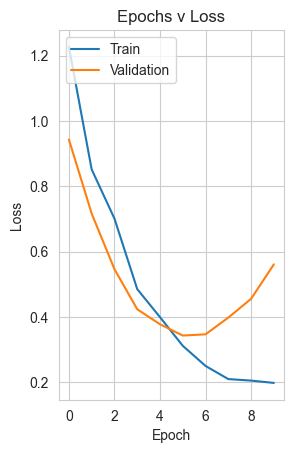

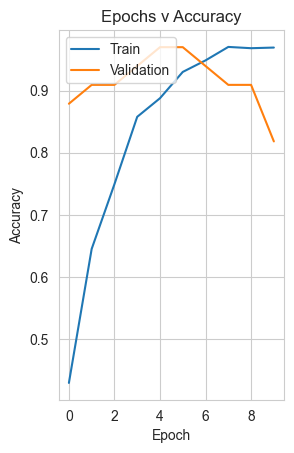

In [18]:
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
from tensorflow.keras import regularizers

cnn_v1 = tf.keras.Sequential()
cnn_v1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v1.add(layers.MaxPooling2D((2, 2)))
cnn_v1.add(layers.Dropout(0.3))

cnn_v1.add(layers.Flatten())
cnn_v1.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1.add(layers.Dropout(0.4))
cnn_v1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1.add(layers.Dropout(0.4))
cnn_v1.add(layers.Dense(4, activation='softmax'))

cnn_v1.build(input_shape=(None, 32, 32, 1))
cnn_v1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v1.summary()

cnn_v1_history = cnn_v1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v1_history.history['loss'])
plt.plot(cnn_v1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v1_history.history['accuracy'])
plt.plot(cnn_v1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,336,740 (16.54 MB)

 Trainable params: 4,336,740 (16.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3601 - loss: 1.4289 - val_accuracy: 0.9091 - val_loss: 0.8761
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6073 - loss: 0.9048 - val_accuracy: 0.8788 - val_loss: 0.5798
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7827 - loss: 0.6384 - val_accuracy: 0.9091 - val_loss: 0.4113
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8629 - loss: 0.4452 - val_accuracy: 0.9091 - val_loss: 0.3875
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9212 - loss: 0.3357 - val_accuracy: 0.9697 - val_loss: 0.2794
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9602 - loss: 0.2398 - val_accuracy: 0.9091 - val_loss: 0.4539
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9762 - loss: 0.1799 - val_accuracy: 0.8788 - val_loss: 0.4180
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9715 - loss: 0.1749 - val_accuracy: 0.9697 - v

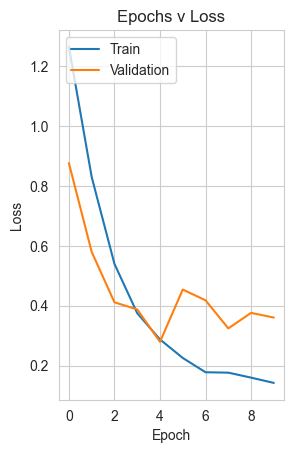

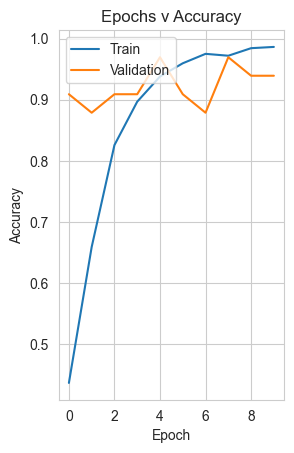

In [19]:
import tensorflow as tf
from keras import models
from keras import layers
tf.keras.backend.clear_session()
from tensorflow.keras import regularizers

cnn_v1_1 = tf.keras.Sequential()
cnn_v1_1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v1_1.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v1_1.add(layers.MaxPooling2D((2, 2)))
cnn_v1_1.add(layers.Dropout(0.3))

cnn_v1_1.add(layers.Flatten())
cnn_v1_1.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1_1.add(layers.Dropout(0.4))
cnn_v1_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v1_1.add(layers.Dropout(0.4))
cnn_v1_1.add(layers.Dense(4, activation='softmax'))

cnn_v1_1.build(input_shape=(None, 32, 32, 1))
cnn_v1_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v1_1.summary()

cnn_v1_1_history = cnn_v1_1.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v1_1.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v1_1.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v1_1_history.history['loss'])
plt.plot(cnn_v1_1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v1_1_history.history['accuracy'])
plt.plot(cnn_v1_1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,295,012 (8.75 MB)

 Trainable params: 2,295,012 (8.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2551 - loss: 1.4630 - val_accuracy: 0.8182 - val_loss: 0.9544
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5641 - loss: 1.0146 - val_accuracy: 0.6970 - val_loss: 0.8438
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6650 - loss: 0.8401 - val_accuracy: 0.9394 - val_loss: 0.4891
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7734 - loss: 0.6754 - val_accuracy: 0.9091 - val_loss: 0.4396
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8395 - loss: 0.4710 - val_accuracy: 0.9394 - val_loss: 0.3702
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8909 - loss: 0.3598 - val_accuracy: 0.9394 - val_loss: 0.4059
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8980 - loss: 0.3422 - val_accuracy: 0.9697 - val_loss: 0.2524
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9108 - loss: 0.2894 - val_accuracy: 0.9394 - v

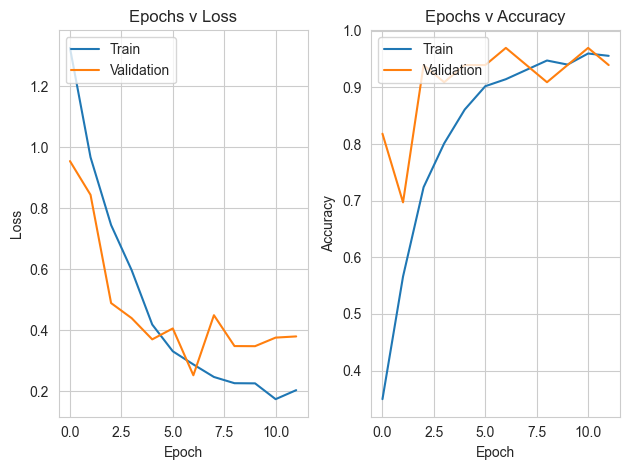

In [20]:
import tensorflow as tf
from keras import layers
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()

cnn_v2 = tf.keras.Sequential()
cnn_v2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v2.add(layers.MaxPooling2D((2, 2)))
cnn_v2.add(layers.Dropout(0.3))

cnn_v2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2a'))
cnn_v2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2b'))
cnn_v2.add(layers.MaxPooling2D((2, 2)))
cnn_v2.add(layers.Dropout(0.3))

cnn_v2.add(layers.Flatten())
cnn_v2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v2.add(layers.Dropout(0.4))
cnn_v2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v2.add(layers.Dropout(0.4))
cnn_v2.add(layers.Dense(4, activation='softmax'))

cnn_v2.build(input_shape=(None, 32, 32, 1))
cnn_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_v2.summary()

cnn_v2_history = cnn_v2.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v2.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v2.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v2_history.history['loss'])
plt.plot(cnn_v2_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_v2_history.history['accuracy'])
plt.plot(cnn_v2_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv2D)                │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,876 (5.60 MB)

 Trainable params: 1,467,876 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2401 - loss: 1.5010 - val_accuracy: 0.3636 - val_loss: 1.3384
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3916 - loss: 1.2866 - val_accuracy: 0.5455 - val_loss: 1.0297
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5792 - loss: 1.0170 - val_accuracy: 0.7879 - val_loss: 0.7371
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6954 - loss: 0.8144 - val_accuracy: 0.8182 - val_loss: 0.5868
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7542 - loss: 0.7002 - val_accuracy: 0.8485 - val_loss: 0.4814
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7712 - loss: 0.6468 - val_accuracy: 0.8788 - val_loss: 0.4526
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7954 - loss: 0.6040 - val_accuracy: 0.8485 - val_loss: 0.5098
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8560 - loss: 0.4738 - val_accuracy: 0.7879 - v

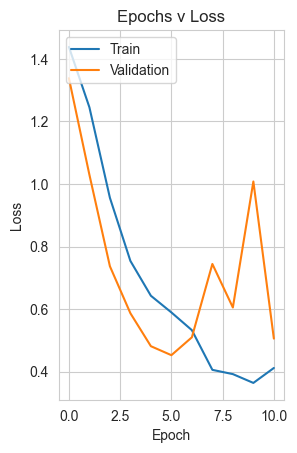

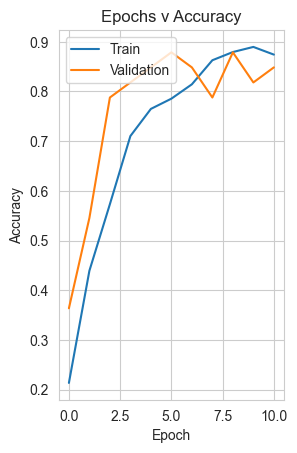

In [21]:
import tensorflow as tf
from keras import layers
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()

cnn_v3 = tf.keras.Sequential()
cnn_v3.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1a'))
cnn_v3.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Dropout(0.3))

cnn_v3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2a'))
cnn_v3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Dropout(0.3))

cnn_v3.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_3a'))
cnn_v3.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_3b'))
cnn_v3.add(layers.MaxPooling2D((2, 2)))
cnn_v3.add(layers.Flatten())
cnn_v3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v3.add(layers.Dropout(0.4))
cnn_v3.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
cnn_v3.add(layers.Dropout(0.4))
cnn_v3.add(layers.Dense(4, activation='softmax'))

cnn_v3.build(input_shape=(None, 32, 32, 1))
cnn_v3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
cnn_v3.summary()
cnn_v3_history = cnn_v3.fit(train_images, transformed_train_labels, epochs=25, validation_data=(val_images, transformed_val_labels),callbacks=[early_stopping],class_weight=class_weight_dict)
train_loss, train_acc = cnn_v3.evaluate(train_images, transformed_train_labels,verbose=1)
print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

val_loss, val_acc = cnn_v3.evaluate(val_images, transformed_val_labels,verbose=1)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

plt.subplot(1, 2, 1)
plt.plot(cnn_v3_history.history['loss'])
plt.plot(cnn_v3_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(cnn_v3_history.history['accuracy'])
plt.plot(cnn_v3_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
test_loss, test_acc = cnn_v1.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v1 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7961 - loss: 0.7020 
CNN v1 Test loss: 0.7044045925140381, Test accuracy: 0.7878788113594055


In [23]:
test_loss, test_acc = cnn_v1_1.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v1.1 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8469 - loss: 0.5824
CNN v1.1 Test loss: 0.5778244733810425, Test accuracy: 0.8484848737716675


In [24]:
test_loss, test_acc = cnn_v2.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v2 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8775 - loss: 0.3909
CNN v2 Test loss: 0.38762056827545166, Test accuracy: 0.8787878751754761


In [25]:
test_loss, test_acc = cnn_v3.evaluate(test_images, transformed_test_labels,verbose=1)
print(f'CNN v3 Test loss: {test_loss}, Test accuracy: {test_acc}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6430 - loss: 1.0341 
CNN v3 Test loss: 1.0421189069747925, Test accuracy: 0.6363636255264282


In [26]:
from sklearn.metrics import classification_report

y_pred = cnn_v1.predict(val_images)
y_pred_classes_1 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_val_labels, y_pred_classes_1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      1.00      1.00         9
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         7

    accuracy                           0.97        33
   macro avg       0.98      0.92      0.94        33
weighted avg       0.97      0.97      0.97        33



In [27]:
y_pred = cnn_v1_1.predict(test_images)
y_pred_classes_1_1 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_1_1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.67      1.00      0.80         8
           2       0.75      1.00      0.86         3
           3       1.00      0.50      0.67         8

    accuracy                           0.85        33
   macro avg       0.85      0.86      0.82        33
weighted avg       0.90      0.85      0.84        33



In [28]:
y_pred = cnn_v2.predict(test_images)
y_pred_classes_2 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_2))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31fade980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.73      1.00      0.84         8
           2       1.00      1.00      1.00

In [29]:
y_pred = cnn_v3.predict(val_images)
y_pred_classes_3 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_val_labels, y_pred_classes_3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       0.90      1.00      0.95         9
           2       1.00      0.33      0.50         3
           3       1.00      0.71      0.83         7

    accuracy                           0.88        33
   macro avg       0.93      0.76      0.80        33
weighted avg       0.90      0.88      0.86        33



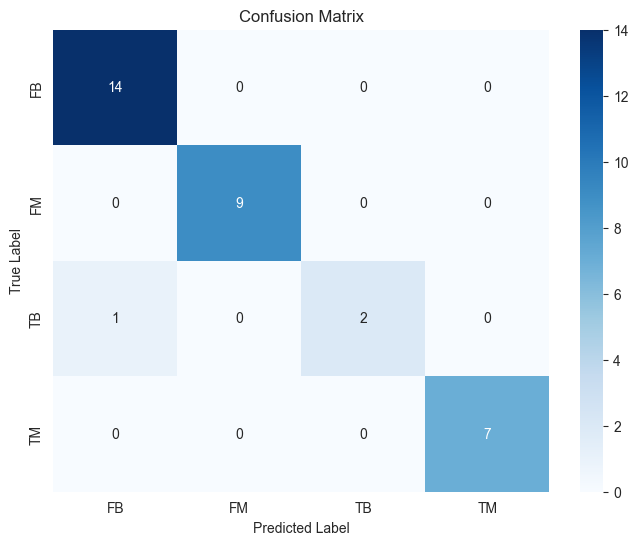

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_1)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

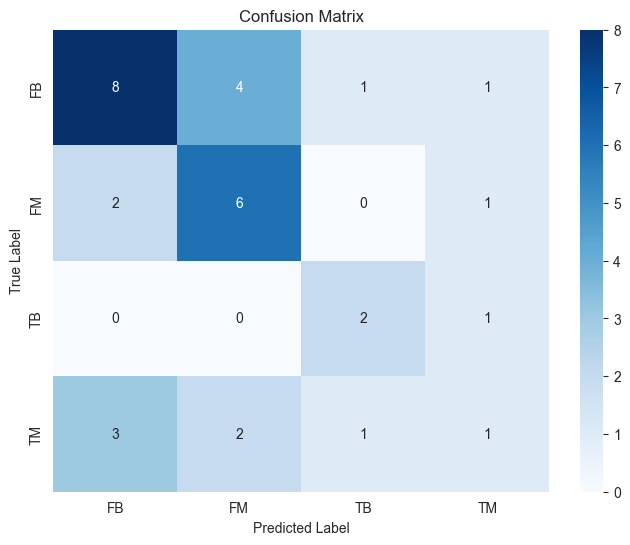

In [31]:
# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_1_1)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

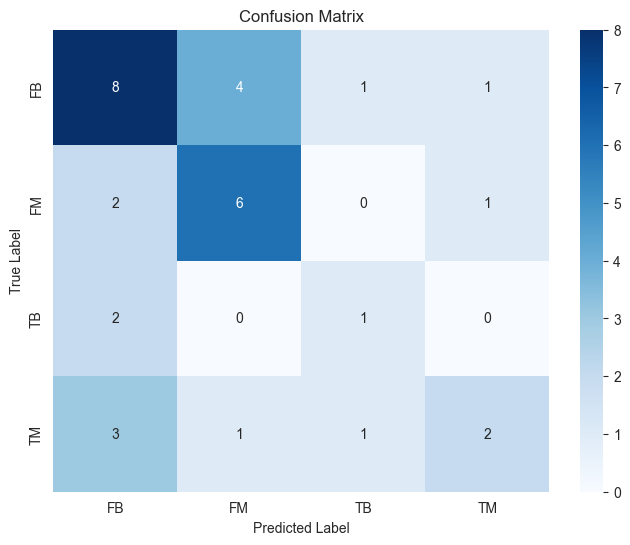

In [32]:
# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_2)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

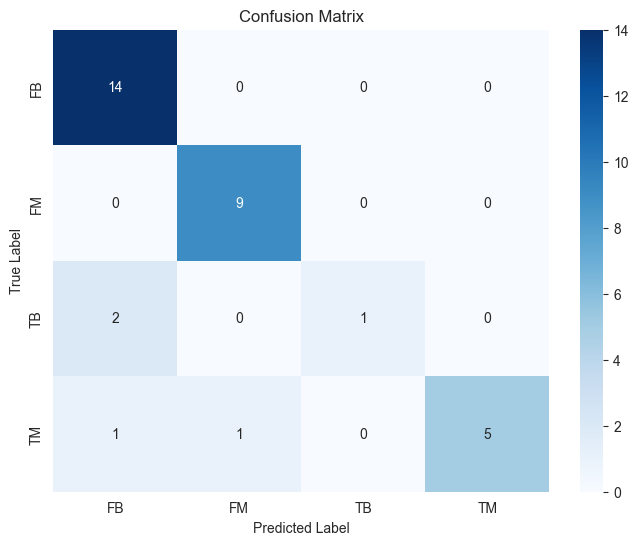

In [33]:
# Generate confusion matrix
cm = confusion_matrix(transformed_val_labels, y_pred_classes_3)

# Get class names from the label encoder
class_names = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

3D CNN Experimentation (Initial model built by Justin)

In [34]:
img_res=(32, 32, 32)
train_image_data = loaded_train_data.reshape((len(loaded_train_data), img_res[0], img_res[1], img_res[2], 1))
val_image_data = loaded_val_data.reshape((len(loaded_val_data), img_res[0], img_res[1], img_res[2], 1))
test_image_data = loaded_test_data.reshape((len(loaded_test_data), img_res[0], img_res[1], img_res[2], 1))
print(train_image_data.shape, val_image_data.shape,test_image_data.shape)

(970, 32, 32, 32, 1) (33, 32, 32, 32, 1) (33, 32, 32, 32, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,112,324 (256.01 MB)

 Trainable params: 67,112,324 (256.01 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4322 - loss: 6.4119 - val_accuracy: 0.7879 - val_loss: 0.7622
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8283 - loss: 0.5409 - val_accuracy: 0.8485 - val_loss: 0.4994
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9313 - loss: 0.2703 - val_accuracy: 0.9091 - val_loss: 0.3984
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9813 - loss: 0.1351 - val_accuracy: 0.9091 - val_loss: 0.3442
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9959 - loss: 0.0671 - val_accuracy: 0.9091 - val_loss: 0.3614
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9949 - loss: 0.0453 - val_accuracy: 0.9091 - val_loss: 0.4322
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 0.9091 - val_loss: 0.4026
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.

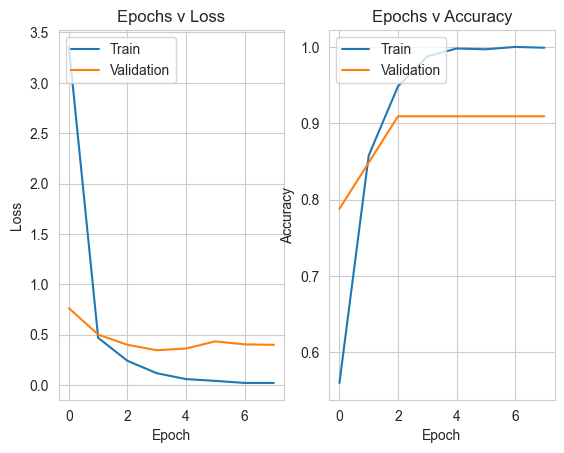

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9818 - loss: 0.1617
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9081 - loss: 0.3961

Train Accuracy: 0.98
Validation Accuracy: 0.91


In [35]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
# initialize model
cnn_3D_v1 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v1.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v1.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v1.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v1.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v1.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v1.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v1.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v1.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v1_history = cnn_3D_v1.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves

plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v1_history.history['loss'])
plt.plot(cnn_3D_v1_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v1_history.history['accuracy'])
plt.plot(cnn_3D_v1_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v1.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v1.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,140,004 (256.12 MB)

 Trainable params: 67,140,004 (256.12 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.2899 - loss: 4.0568 - val_accuracy: 0.4242 - val_loss: 1.3708
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.4327 - loss: 1.3630 - val_accuracy: 0.4242 - val_loss: 1.3415
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.4327 - loss: 1.3331 - val_accuracy: 0.4242 - val_loss: 1.3133
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 1690s 56s/step - accuracy: 0.4327 - loss: 1.3057 - val_accuracy: 0.4242 - val_loss: 1.2915
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.4327 - loss: 1.2856 - val_accuracy: 0.4242 - val_loss: 1.2786
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.4327 - loss: 1.2745 - val_accuracy: 0.4242 - val_loss: 1.2729
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


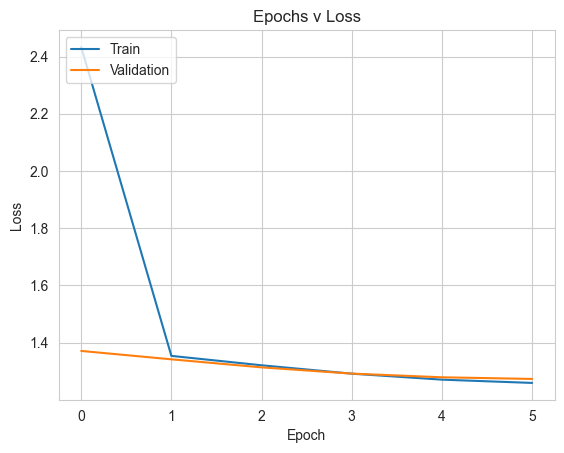

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.3956 - loss: 1.3734
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4287 - loss: 1.3701 

Train Accuracy: 0.45
Validation Accuracy: 0.42


In [36]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
# initialize model
tf.keras.backend.clear_session()

cnn_3D_v2 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v2.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v2.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v2.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v2.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v2.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v2.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v2.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v2.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v2.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
history = cnn_3D_v2.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v2.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v2.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv3D)                │ (None, 16, 16, 16, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv3D)                │ (None, 16, 16, 16, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,974,372 (64.75 MB)

 Trainable params: 16,974,372 (64.75 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.3908 - loss: 1.4567 - val_accuracy: 0.6667 - val_loss: 0.9563
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6968 - loss: 0.8368 - val_accuracy: 0.7273 - val_loss: 0.6001
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.7813 - loss: 0.5629 - val_accuracy: 0.7576 - val_loss: 0.4893
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.8549 - loss: 0.3737 - val_accuracy: 0.8788 - val_loss: 0.3725
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.9117 - loss: 0.2268 - val_accuracy: 0.8788 - val_loss: 0.3525
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9609 - loss: 0.0991 - val_accuracy: 0.9091 - val_loss: 0.3551
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.9680 - loss: 0.0947 - val_accuracy: 0.9091 - val_loss: 0.2953
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accura

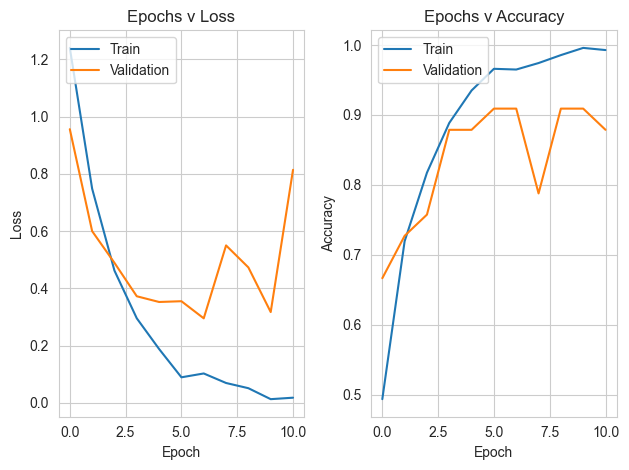

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step - accuracy: 0.9742 - loss: 0.0804
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9186 - loss: 0.3282 

Train Accuracy: 0.98
Validation Accuracy: 0.91


In [37]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
tf.keras.backend.clear_session()

# initialize model
cnn_3D_v3 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v3.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v3.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v3.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

cnn_3D_v3.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2a',
  activation='relu'
))
cnn_3D_v3.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2b',
  activation='relu'
))
cnn_3D_v3.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v3.add(layers.Dropout(rate=0.4))

# add a flattening layer
cnn_3D_v3.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v3.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v3.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v3.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v3.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v3_history = cnn_3D_v3.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v3_history.history['loss'])
plt.plot(cnn_3D_v3_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v3_history.history['accuracy'])
plt.plot(cnn_3D_v3_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v3.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v3.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1a (Conv3D)                │ (None, 32, 32, 32, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv3D)                │ (None, 32, 32, 32, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 16, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv3D)                │ (None, 16, 16, 16, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv3D)                │ (None, 16, 16, 16, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv3D)                │ (None, 8, 8, 8, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv3D)                │ (None, 8, 8, 8, 128)   │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,415,396 (131.28 MB)

 Trainable params: 34,415,396 (131.28 MB)

 Non-trainable params: 0 (0.00 B)

(970, 32, 32, 32, 1) (970,) (33, 32, 32, 32, 1) (33,)
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.3902 - loss: 2.1437 - val_accuracy: 0.5758 - val_loss: 1.1996
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.6155 - loss: 1.0587 - val_accuracy: 0.8182 - val_loss: 0.6587
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.7190 - loss: 0.7070 - val_accuracy: 0.7879 - val_loss: 0.4700
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.7960 - loss: 0.5276 - val_accuracy: 0.8788 - val_loss: 0.4006
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.8580 - loss: 0.3916 - val_accuracy: 0.8788 - val_loss: 0.4687
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.8949 - loss: 0.2844 - val_accuracy: 0.8485 - val_loss: 0.4605
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.9253 - loss: 0.2138 - val_accuracy: 0.7576 - val_loss: 0.5671
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accu

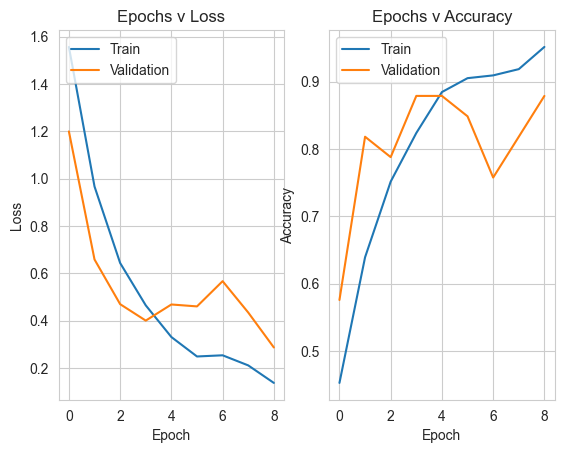

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 519ms/step - accuracy: 0.8390 - loss: 0.4228
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8775 - loss: 0.3971 

Train Accuracy: 0.85
Validation Accuracy: 0.88


In [38]:
import matplotlib.pyplot as plt

#Establish number of classes we need to predict
classes = 4
#Hyperparameters
lr = 0.001
tf.keras.backend.clear_session()

# initialize model
cnn_3D_v4 = tf.keras.Sequential()

# add convolutional layer
cnn_3D_v4.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1a',
  activation='relu'
))

cnn_3D_v4.add(layers.Conv3D(
  filters=32,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_1b',
  activation='relu'
))
cnn_3D_v4.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

cnn_3D_v4.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2a',
  activation='relu'
))
cnn_3D_v4.add(layers.Conv3D(
  filters=64,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_2b',
  activation='relu'
))
cnn_3D_v4.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# add dropout layer
cnn_3D_v4.add(layers.Dropout(rate=0.4))

cnn_3D_v4.add(layers.Conv3D(
  filters=128,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_3a',
  activation='relu'
))
cnn_3D_v4.add(layers.Conv3D(
  filters=128,
  kernel_size=(3, 3, 3),
  strides=(1, 1, 1),
  padding='same',
  data_format='channels_last',
  name='conv_3b',
  activation='relu'
))

# add a flattening layer
cnn_3D_v4.add(layers.Flatten())

# add a Dense Layer
cnn_3D_v4.add(layers.Dense(units=512, activation='relu'))

# add the classification layer
cnn_3D_v4.add(layers.Dense(units=classes, activation='softmax',kernel_regularizer=regularizers.l2(1e-4))) #4 classes (softmax for multi-class)

# build and compile model
cnn_3D_v4.build(input_shape=(None, 32, 32, 32, 1))
cnn_3D_v4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Since we are using Sparse encodings (not One-Hot Dense....)
              metrics=['accuracy'])

# print model_tf summary
cnn_3D_v4.summary()

# train model_tf on (X_train, y_train) data
print(train_image_data.shape, transformed_train_labels.shape,val_image_data.shape, transformed_val_labels.shape)
cnn_3D_v4_history = cnn_3D_v4.fit(
    train_image_data,
    transformed_train_labels,
    validation_data=(val_image_data, transformed_val_labels),
    epochs=15,
    callbacks=[early_stopping]
)

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(cnn_3D_v4_history.history['loss'])
plt.plot(cnn_3D_v4_history.history['val_loss'])
plt.title('Epochs v Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_3D_v4_history.history['accuracy'])
plt.plot(cnn_3D_v4_history.history['val_accuracy'])
plt.title('Epochs v Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_loss, train_acc = cnn_3D_v4.evaluate(train_image_data, transformed_train_labels, verbose=1)
val_loss, val_acc = cnn_3D_v4.evaluate(val_image_data, transformed_val_labels, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")

In [39]:
test_loss, test_acc = cnn_3D_v1.evaluate(test_image_data, transformed_test_labels, verbose=1)
print(f"3D CNN v1 Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7348 - loss: 0.6279 
3D CNN v1 Test Accuracy: 0.73


In [40]:
test_loss, test_acc = cnn_3D_v3.evaluate(test_image_data, transformed_test_labels, verbose=1)
print(f"3D CNN v3 Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7244 - loss: 1.9199 
3D CNN v3 Test Accuracy: 0.73


In [41]:
test_loss, test_acc = cnn_3D_v4.evaluate(test_image_data, transformed_test_labels, verbose=1)
print(f"3D CNN v4 Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6430 - loss: 1.0776 
3D CNN v4 Test Accuracy: 0.64


In [42]:
from sklearn.metrics import classification_report

y_pred = cnn_3D_v1.predict(test_image_data)
y_pred_classes_1 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.58      0.88      0.70         8
           2       0.50      0.33      0.40         3
           3       0.67      0.25      0.36         8

    accuracy                           0.73        33
   macro avg       0.66      0.61      0.60        33
weighted avg       0.72      0.73      0.69        33



In [43]:
y_pred = cnn_3D_v3.predict(test_image_data)
y_pred_classes_3 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step 
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       0.55      0.75      0.63         8
           2       1.00      0.33      0.50         3
           3       0.75      0.38      0.50         8

    accuracy                           0.73        33
   macro avg       0.78      0.61      0.63        33
weighted avg       0.75      0.73      0.70        33



In [44]:
y_pred = cnn_3D_v4.predict(test_image_data)
y_pred_classes_4 = np.argmax(y_pred, axis=1)
print(classification_report(transformed_test_labels, y_pred_classes_4))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.40      0.75      0.52         8
           2       0.00      0.00      0.00         3
           3       0.33      0.12      0.18         8

    accuracy                           0.64        33
   macro avg       0.42      0.47      0.42        33
weighted avg       0.57      0.64      0.58        33



/Users/vishnugorur/PycharmProjects/pythonProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vishnugorur/PycharmProjects/pythonProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vishnugorur/PycharmProjects/pythonProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 